1. Beskriv kort hur en relationsdatabas fungerar.

En relationsdatabas organiserar data i tabeller som har rader och kolumner.
•	Varje rad är en unik post.
•	Kolumnerna innehåller information som beskriver posterna.
Viktiga begrepp:
•	Primärnyckel (Primary Key): En unik identifierare för varje rad i en tabell.
•	Främmande nyckel (Foreign Key): Används för att koppla ihop tabeller genom att referera till primärnycklar i andra tabeller.
•	Relationer: Genom att använda främmande nycklar och primärnycklar kan man länka tabeller. Det gör det möjligt att kombinera och analysera data på många olika sätt.
En stor fördel med relationsdatabaser är att de hjälper till att hålla data korrekt och undvika onödig dubbel information. Detta görs genom något som kallas normalisering. Man använder SQL (Structured Query Language) för att hämta och ändra data i databasen på ett enkelt och effektivt sätt.




2. Vad menas med “CRUD”-flödet?
CRUD är en förkortning som beskriver fyra viktiga saker man kan göra med data i en relationsdatabas:
1.	Create (Skapa): Lägga till nya poster i databasen, till exempel när man registrerar en ny kund i en kundtabell.
2.	Read (Läsa): Hämta eller läsa data från databasen utan att ändra något. Detta är det som används mest.
3.	Update (Uppdatera): Ändra eller rätta till information i befintliga poster, till exempel uppdatera en kunds adress.
4.	Delete (Ta bort): Ta bort poster från databasen, som att radera en gammal eller felaktig post.
CRUD är grunden för hur man jobbar med databaser och ett viktigt sätt att förstå hur man hanterar data.



3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?

Left Join
En left join kombinerar data från två tabeller och returnerar alla rader från den vänstra tabellen, även om det inte finns någon matchning i den högra tabellen. För rader utan matchning i den högra tabellen fylls kolumnerna från den högra tabellen med NULL.
Användning:
Används när du vill inkludera all data från en tabell och eventuell matchande data från en annan.
Exempel: Lista alla kunder och deras ordrar, även de kunder som inte har lagt några ordrar.

Inner Join
En inner join returnerar endast de rader där det finns en matchning mellan båda tabellerna. Om det inte finns någon matchande rad i den andra tabellen, inkluderas inte raden i resultatet.
Användning:
Används för att hämta data som har en relation mellan två tabeller.
Exempel: Lista endast de kunder som faktiskt har lagt ordrar.

Skillnaden mellan Left Join och Inner Join:
Left Join:
Inkluderar alla rader från den vänstra tabellen oavsett om det finns en matchning i den högra tabellen.
Användbart när du vill behålla alla data från huvudtabellen och visa relaterad information om den finns.
Inner Join:
Returnerar endast rader med matchningar mellan båda tabellerna.
Användbart när du bara vill se data där det finns en relation mellan tabellerna.


4. Beskriv kort vad indexering i SQL innebär.

Indexering i SQL används för att göra sökningar i en databas snabbare. Ett index är som en lista som skapas på en eller flera kolumner i en tabell och hjälper systemet att snabbt hitta specifika rader utan att behöva leta igenom hela tabellen.

Utan index måste databasen läsa varje rad för att hitta det du söker, vilket kan ta lång tid, särskilt i stora tabeller. Med index kan databasen snabbt hitta rätt rader.

Exempel:
Om man har en kolumn med kund-ID och skapar ett index där, kan systemet snabbt hitta en specifik kund.

Vanliga typer av index:

Klustrade index: Sorterar och lagrar tabellens data enligt indexet. Varje tabell kan bara ha ett klustrat index.
Icke-klustrade index: Skapar en separat lista som pekar på datan i tabellen utan att ändra ordningen på tabellen. En tabell kan ha flera icke-klustrade index.
Nackdelar:
Indexering kan göra det långsammare att lägga till, ändra eller ta bort data, eftersom indexen också måste uppdateras varje gång datan ändras.




5. Beskriv kort vad en vy i SQL är.

En vy i SQL är som ett fönster till data i en tabell eller flera tabeller. Den är en virtuell tabell som visar resultatet av en fråga, men den lagrar inte data själv.

Man använder vyer för att:

Göra det enklare att arbeta med komplex data.
Visa bara den information som är viktig för en användare.
Öka säkerheten genom att begränsa åtkomst till vissa delar av datan.
Exempel:
Om man har en tabell med kundinformation och bara vill visa namn och e-postadresser, kan du skapa en vy som visar just den informationen.



6.	Beskriv kort vad en lagrad procedur i SQL är.

En lagrad procedur i SQL är ett färdigt program eller en samling av SQL-kommandon som sparas i databasen. Den kan köras flera gånger för att utföra samma uppgifter utan att behöva skriva om koden varje gång.

Varför använda lagrade procedurer?

Gör det enklare att automatisera uppgifter, som att lägga till, uppdatera eller ta bort data.
Sparar tid eftersom du kan använda samma kod flera gånger.
Ökar säkerheten genom att dölja detaljerna i hur data hanteras.
Exempel:
En lagrad procedur kan användas för att lägga till en ny kund i en tabell. Man skickar bara in informationen (som namn och adress), och proceduren sköter resten.



Deskriptiv sammanfattning

AdventureWorks2022 är en relationsdatabas som innehåller flera scheman med olika typer av affärsdata. Två av de viktigaste schemana är:

Sales: Innehåller 15 tabeller relaterade till kundorder och försäljning.
Production: Innehåller 20 tabeller med fokus på produktionsdata.
Viktiga tabeller:

Sales.SalesOrderHeader – Lagrar detaljer om kundorder.
Production.Product – Listar alla produkter och deras kategorier.
HumanResources.Employee – Innehåller personalinformation.
Databasen använder relationer mellan tabeller, som främmande nycklar, för att koppla kundorder till kunder. Detta gör det möjligt att analysera affärsflöden och identifiera mönster. En analys av kunddata visar att vissa kunder har betydligt fler ordrar än andra, vilket kan tyda på lojala kunder och skapa möjligheter till riktad marknadsföring.

Jag har gått igenom alla tabeller i databasen och valt flera tabeller och kolumner för att skapa en specifik fråga. Syftet var att kombinera data från olika tabeller för att analysera affärsflöden och generera insiktsfulla rapporter. 
SQL-kod som användes:
1-	
USE [AdventureWorks2022];

SELECT soh.SalesOrderNumber
      ,soh.PurchaseOrderNumber
      ,soh.CustomerID
      ,soh.CurrencyRateID
      ,soh.SubTotal
      ,soh.TaxAmt
      ,soh.Freight
      ,soh.TotalDue
      ,sod.OrderQty
      ,sod.ProductID
      ,sod.SpecialOfferID
      ,sod.UnitPrice
      ,sod.UnitPriceDiscount
      ,sod.LineTotal
      ,sohsr.SalesReasonID
      ,sr.Name
      ,c.PersonID
      ,c.StoreID
      ,sop.ProductID
      ,so.Description
      ,so.DiscountPct
      ,so.Type
      ,so.Category
      ,so.StartDate
      ,so.EndDate
      ,so.MinQty
      ,so.MaxQty
  FROM Sales.SalesOrderHeader soh
  INNER JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
  INNER JOIN Sales.SalesOrderHeaderSalesReason sohsr ON soh.SalesOrderID = sohsr.SalesOrderID
  INNER JOIN Sales.SalesReason sr ON sohsr.SalesReasonID = sr.SalesReasonID
  INNER JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
  INNER JOIN Sales.SpecialOfferProduct sop ON sop.SpecialOfferID = sod.SpecialOfferID
  INNER JOIN Sales.SpecialOffer so ON so.SpecialOfferID = sod.SpecialOfferID;
Den här frågan kombinerar data från flera tabeller för att ge detaljerad information om försäljning, produkter, rabatter och orsaker till kundorder, vilket kan användas för att optimera affärsstrategier.



2-	Lista alla tabeller:
Visar alla tabeller och deras schema i databasen.
SELECT TABLE_SCHEMA, TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE'
ORDER BY TABLE_SCHEMA ASC, TABLE_NAME ASC;


3-	Antal tabeller per schema:
Räknar antalet tabeller i varje schema. 
SELECT TABLE_SCHEMA, COUNT(*) AS TableCount
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE'
GROUP BY TABLE_SCHEMA
ORDER BY TABLE_SCHEMA ASC;


4-	Kunder med flest ordrar:
Sorterar kunder efter antal ordrar i fallande ordning.
SELECT CustomerID, COUNT(*) AS TotalOrders
FROM Sales.SalesOrderHeader
GROUP BY CustomerID
ORDER BY TotalOrders DESC;


 1. En deskriptiv sammanfattning över databasen
 

In [20]:
import matplotlib 
matplotlib.use("TkAgg")
%matplotlib inline
import pandas as pd
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
from IPython.display import display

In [26]:
# Define  connection parameters
server_name = 'IZAC'  # Replace with  server name
database_name = 'AdventureWorks2022'  # Replace with  database name


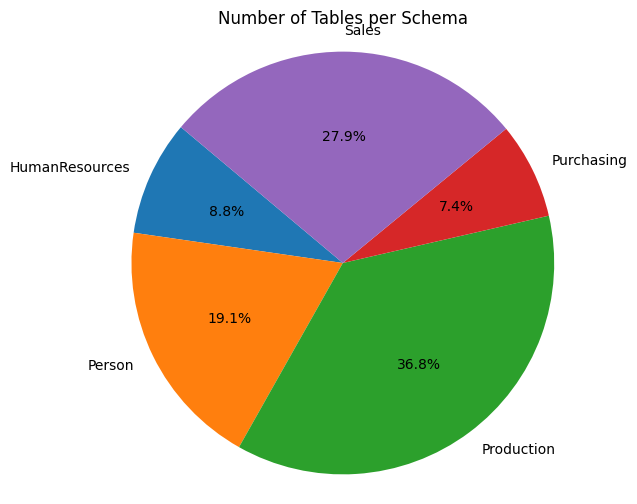

In [22]:
query = """
SELECT TABLE_SCHEMA, COUNT(*) AS TableCount
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE'
AND TABLE_SCHEMA != 'dbo' 
GROUP BY TABLE_SCHEMA
ORDER BY TABLE_SCHEMA ASC;
"""

# Execute the query and store the result in a DataFrame
df = pd.read_sql(query, engine)

# Visualize the data in a pie chart
plt.figure(figsize=(6, 6))
plt.pie(df['TableCount'], labels=df['TABLE_SCHEMA'], autopct='%1.1f%%', startangle=140)
plt.title('Number of Tables per Schema')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

,SalesReason,Occurrences,TotalRevenueUSD
0,Price,20580,4779212
1,On Promotion,3416,3227436
2,Manufacturer,972,3219460
3,Quality,835,2987855
4,Review,797,879312
5,Other,1624,113607
6,Television Advertisement,344,13314


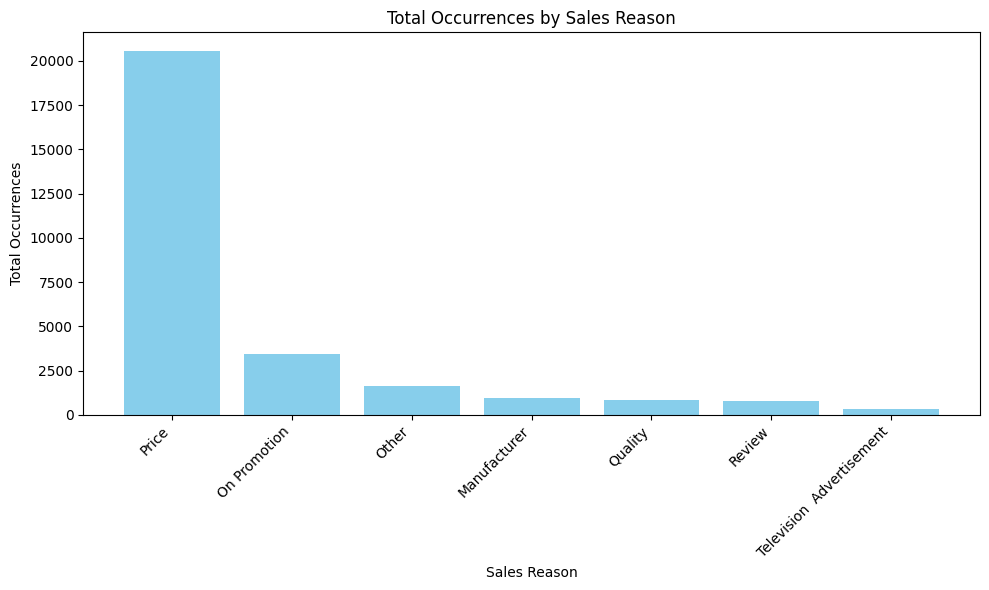

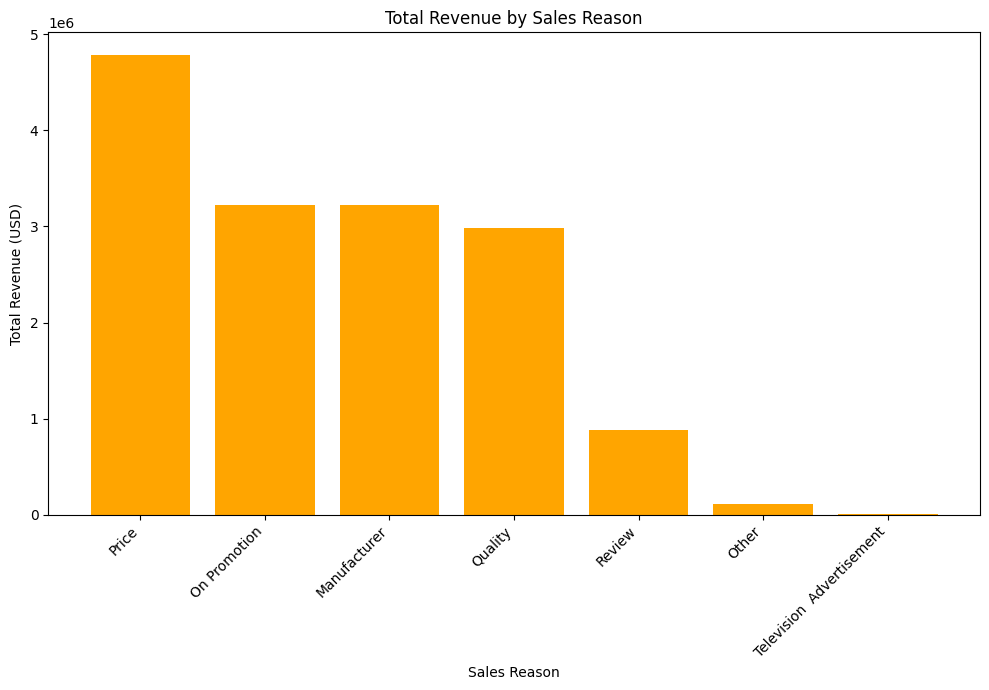

In [27]:
query = """
    SELECT sr.Name AS SalesReason,
       COUNT(sohsr.SalesOrderID) AS Occurrences,
       SUM(
           CASE 
               WHEN cr.FromCurrencyCode = 'USD' THEN sod.LineTotal
               ELSE sod.LineTotal * cr.EndOfDayRate
           END
       ) AS TotalRevenueUSD
    FROM Sales.SalesReason sr
    INNER JOIN Sales.SalesOrderHeaderSalesReason sohsr
        ON sr.SalesReasonID = sohsr.SalesReasonID
    INNER JOIN Sales.SalesOrderHeader soh
        ON sohsr.SalesOrderID = soh.SalesOrderID
    INNER JOIN Sales.CurrencyRate cr
        ON soh.CurrencyRateID = cr.CurrencyRateID
    INNER JOIN Sales.SalesOrderDetail sod
        ON soh.SalesOrderID = sod.SalesOrderID
    GROUP BY sr.Name
    ORDER BY TotalRevenueUSD DESC;
  """


# Load query results into a DataFrame
df = pd.read_sql(query, engine)
df["TotalRevenueUSD"] = df["TotalRevenueUSD"].apply(lambda x: int(x + 0.5))
display(df)

    

    
#Sort the DataFrame by 'Occurrences' for the occurrences plot
df_sorted_occurrences = df.sort_values(by="Occurrences", ascending=False)
    
#Plot Total Occurrences by Sales Reason
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(df_sorted_occurrences["SalesReason"], df_sorted_occurrences["Occurrences"], color="skyblue")
ax2.set_xlabel("Sales Reason")
ax2.set_ylabel("Total Occurrences")
ax2.set_title("Total Occurrences by Sales Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



#Sort the DataFrame by 'TotalRevenueUSD' for the revenue plot
df_sorted_revenue = df.sort_values(by="TotalRevenueUSD", ascending=False)
    
#Plot Total Revenue by Sales Reason
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.bar(df_sorted_revenue["SalesReason"], df_sorted_revenue["TotalRevenueUSD"], color="orange")
ax1.set_xlabel("Sales Reason")
ax1.set_ylabel("Total Revenue (USD)")
ax1.set_title("Total Revenue by Sales Reason")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

2. Statistisk analys

In [24]:
import numpy as np
from scipy import stats

mean_revenue = df['TotalRevenueUSD'].mean()
std_revenue = df['TotalRevenueUSD'].std(ddof=1) 

# Provsstorlek
n = len(df['TotalRevenueUSD'])

# Standardfel
se = std_revenue / np.sqrt(n)

# Kritiskt värde för 95% konfidens
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)

# Felmarginal
margin_error = t_critical * se


ci_lower = mean_revenue - margin_error
ci_upper = mean_revenue + margin_error


print(f"95% konfidensintervall för medelvärdet av Total Revenue (USD): ({ci_lower:.2f}, {ci_upper:.2f})")


95% konfidensintervall för medelvärdet av Total Revenue (USD): (475590.71, 3873036.72)


3. Excutive summery

Den här analysen visar att priset på en produkt är en mycket viktig faktor för både hur mycket som säljs och vilken vinst som görs. Detta är en viktig insikt för chefer som vill fatta smarta beslut.

Resultat
Total Occurrences by Sales Reason: Produkter med lägre pris säljer oftare. Det betyder att det finns ett starkt samband mellan hur lågt priset är och hur många som köper.
Total Revenue by Sales Reason: Intäkterna (den totala inkomsten) påverkas också av pris och kvalitet. Även om produkter med lägre pris säljer mer, kan de ge mindre vinst per såld enhet.
Prisets betydelse: Pris är en av de viktigaste faktorerna för att öka både försäljningen och vinsten.
Kvalitetens roll: Det är viktigt att även lågprisprodukter håller en bra kvalitet. Det kan göra att kunderna blir mer nöjda och kommer tillbaka.
Rekommendationer till chefer
Justera priser: Fundera på att sänka priset på vissa produkter som kan sälja mycket mer, om det går att göra utan att förlora för mycket vinst.
Förbättra kvaliteten: Gör lågprisprodukter ännu bättre för att locka fler kunder och stärka företagets rykte.
Analysera marknaden: Ta reda på hur mycket kunderna är villiga att betala och anpassa priset därefter.
Rikta kampanjer rätt: Identifiera de kunder som är mest känsliga för pris och skapa erbjudanden särskilt för dem.
Följ upp regelbundet: Fortsätt att övervaka hur pris och kvalitet påverkar försäljning och vinst för att kunna göra förbättringar i framtiden.
Dessa steg kan hjälpa företaget att både sälja mer och öka sin konkurrenskraft på marknaden.

Jag gjorde min muntliga presentation av koden fredagen den 3 januari 2025.

 Självvärdering

  1. Utmaningar du haft under arbetet samt hur du hanterat dem.
  Under arbetet hade jag vissa utmaningar, som att förstå hur jag skulle koppla databasen till analysverktygen och skriva avancerade SQL-frågor. Jag lärde mig också att testa koden i små delar för att lättare hitta och lösa problem.
  

   2. Vilket betyg du anser att du skall ha och varför.
    Jag hoppas att jag förtjänar ett VG betyg, eftersom jag har lagt ner mycket tid och arbete på uppgiften. 


    3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.
    Ett tips till mig själv hade varit att börja med att läsa in mig ordentligt på grunderna i databaser och SQL. Jag hade också sagt att det är okej att göra fel – det är så man lär sig. Dessutom hade jag rekommenderat att planera tiden bättre och arbeta kontinuerligt istället för att stressa i slutet.